In [ ]:
#Importing the required libraries
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
import urllib.request
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
from sklearn.preprocessing import LabelEncoder
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


As the images were in different files with the file names being the labels of the images, the images had to be extracted individually from the files and their labels preserved.

To extract the files a two empty lists were created for train and test images and their labels. A classes list was then created to extract all their names form the files using the OS python module. The module first checked if the if the path specified is a directory and adds the name of the directory to the list classes. The if loop then joins the names of the path and the directory and opens the images. it then resizes the image to a 34 by 34 pixel. It then saves the image as a Numpy array in the train_images list and adds the labels of the image extracted from classes list to the train_labels list. The same actions were carried out for the test set provided.



In [ ]:
#Directory where the files were located
dir = "/content/drive/MyDrive/Images_dataset/_train"

#creating a list of the file names
classes = [cls.name for cls in os.scandir(dir) if cls.is_dir()]

#Creating empty lists
train_images, train_labels = [], []

#itterating through the file names to create a file path for image extraction
for i in classes:
    file = os.path.join(dir, i)
    for img in os.listdir(file):
        img_file = os.path.join(file, img)
        image = Image.open(img_file)

        #Resizing the image
        image = image.resize((34, 34))

        #Saving the image as a numpy array
        train_images.append(np.array(image))

        #Adding the image label to the labels list
        train_labels.append(str(i))

train_images = np.array(train_images)


print("train_images shape:", train_images.shape)
print("train_labels shape:", len(train_labels))


train_images shape: (5959, 34, 34, 3)
train_labels shape: 5959


In [ ]:
dir = "/content/drive/MyDrive/Images_dataset/_test"
classes = [cls.name for cls in os.scandir(dir) if cls.is_dir()]

test_images, test_labels = [], []
for i in classes:
    file = os.path.join(dir, i)
    for img in os.listdir(file):
        img_file = os.path.join(file, img)
        image = Image.open(img_file)
        image = image.resize((34, 34))
        test_images.append(np.array(image))
        test_labels.append(str(i))

test_images = np.array(test_images)


print("test_images shape:", test_images.shape)
print("test_labels shape:", len(test_labels))

test_images shape: (940, 34, 34, 3)
test_labels shape: 940


The list of images and the labels were viewed in a dataframe to visulaize how they look. Since the training set is a list, these had to be converted into a dictionary with the keys being the numpy array and the items the labels.

In [ ]:
#converting the lists to a pandas dataframe to visualize the data
df = {'Image': train_images.tolist(), 'Label': train_labels}
df = pd.DataFrame(df)
df.head(10)

,Image,Label
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",fruit
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",fruit
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",fruit
3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",fruit
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",fruit
5,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",fruit
6,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",fruit
7,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",fruit
8,"[[[255, 255, 253], [254, 254, 255], [253, 254,...",fruit
9,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",fruit


# Data Exploration

To check if the correct order of images were extarcted randon images along with their labels were plotted.

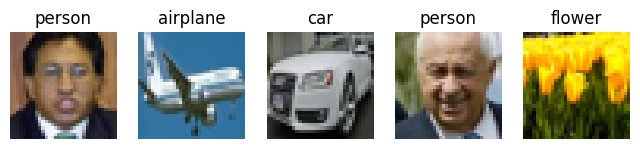

In [ ]:
#Selecting 5 random indicies of the train_images
im = random.sample(range(len(train_images)), 5)
pltimages = train_images[im]
#Selecting the same indicies in the train_label list
pltlabels = [train_labels[i] for i in im]
fig, axes = plt.subplots(1, 5, figsize=(8, 8))
#Using the enumerate function to itterrate over the pltimages variable and disply the images
for i, j in enumerate(pltimages):
    axes[i].imshow(j)
    axes[i].axis('off')
    axes[i].set_title(pltlabels[i])

plt.show()

The same was done for the test images so ensure that the images and their labels match.

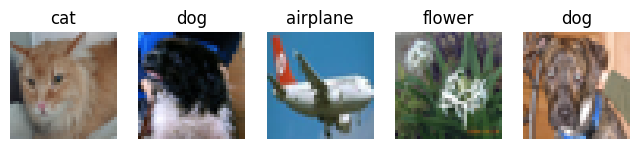

In [ ]:
im = random.sample(range(len(test_images)), 5)
pltimages = test_images[im]
pltlabels = [test_labels[i] for i in im]
fig, axes = plt.subplots(1, 5, figsize=(8, 8))
for i, j in enumerate(pltimages):
    axes[i].imshow(j)
    axes[i].axis('off')
    axes[i].set_title(pltlabels[i])

plt.show()

The count of each image type needs to be know to understand the distribution of data. Ideally, the number of images of each class or label should be equally distributed so that machine prediction models can learn efficiently from the equal distribution of features and not have a bias towards the majority class. Deep neural networks can handle slight imbalances in the distribution of data due to their ability to learn complex features and patterns.

The distribution of images below shows that car images are the majority class followed by the images of a fruit and a person. The images of a dog and an airplane are the minority class.

In [ ]:
#Counting the number of each type of image
df['Label'].value_counts()


car          871
fruit        850
person       838
cat          797
flower       717
motorbike    670
airplane     619
dog          597
Name: Label, dtype: int64

For a better visualization of the distribution, the count of each type of image in the training set were plotted.

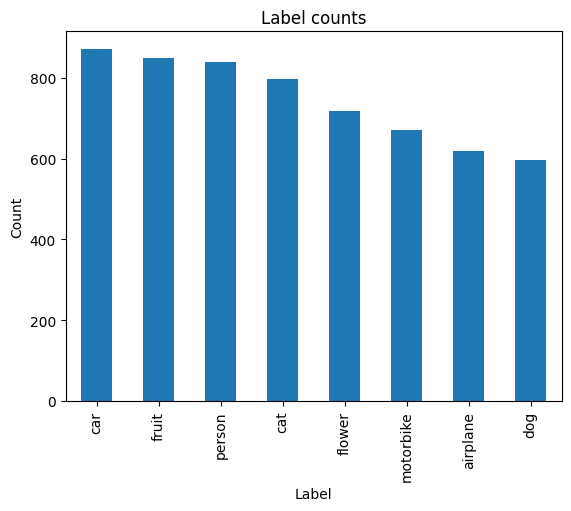

In [ ]:
#Plotting the distribution from the value counts of the dataframe created above
counts = df['Label'].value_counts()
counts.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label counts')
plt.show()

Since the images and their labels were extracted in an ordered  manner, with all the images following a sequence, the lists have to be shuffled. This is done because the neural network could memorize the pattern of the images and their labels, this would increase the bias of the model and the model might not generalize well when presented with the test set. To shuffle the images and the labels, Skit Learn's shuffle module was utilized. This module shuffles the images and their labels in a random manner while maintaining the order of both the lists.



In [ ]:
#Shuffling both the image and the labels lists
train_images,train_labels=sklearn.utils.shuffle(train_images,train_labels)

The train images and the labels are again put in a data frame format to observe the changes. As before, random images were plotted along with their labels to ensure that the shuffling preserved the connection between the image and their labels.

In [ ]:
df = {'Image': train_images.tolist(), 'Label': train_labels}
df = pd.DataFrame(df)
df.head(10)

,Image,Label
0,"[[[85, 87, 82], [108, 71, 54], [116, 75, 58], ...",airplane
1,"[[[103, 129, 82], [100, 120, 72], [99, 119, 79...",flower
2,"[[[76, 102, 72], [79, 106, 76], [80, 111, 76],...",airplane
3,"[[[121, 123, 119], [117, 119, 116], [117, 118,...",dog
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",fruit
5,"[[[79, 117, 150], [83, 127, 159], [177, 201, 2...",airplane
6,"[[[237, 234, 238], [237, 235, 240], [238, 233,...",car
7,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",fruit
8,"[[[51, 75, 53], [51, 73, 52], [52, 74, 47], [6...",flower
9,"[[[44, 67, 23], [53, 75, 25], [37, 49, 15], [3...",flower


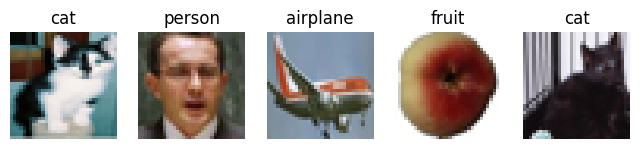

In [ ]:
im = random.sample(range(len(train_images)), 5)
pltimages = train_images[im]
pltlabels = [train_labels[i] for i in im]
fig, axes = plt.subplots(1, 5, figsize=(8, 8))
for i, j in enumerate(pltimages):
    axes[i].imshow(j)
    axes[i].axis('off')
    axes[i].set_title(pltlabels[i])

plt.show()

# Feature Engineering

The labels of the images are in a string format and deep neural networks require their integer representation for training. To convert the labels to numerical values Skit learn's Label Encoder utility was used. This assigns a unique value to each label. The value of the labels was then mapped and saved in a variable. The target variable are then converted to a 2d array using the Keras to categorical utility. This is usually done for deep neural network for various reasons such as compatibility with a loss functions and ease of model prediction interpretation where, the model calculates the probability of each class and its easier to compare the predicted probabilities with that of the true class. Hence both the train and test labels were label encoded and One Hot Encoded into a vector of class 8 (since there are 8 diffrent image labels). The output will be a 2d array.


In [ ]:
#Initializing the label encoder
label_encoder = LabelEncoder()

#Training and encoding the labels
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.fit_transform(test_labels)

#Mapping the encoded labels to their classes
train_labels_mapping=label_encoder.classes_
test_labels_mapping=label_encoder.classes_


#One hot encoding the classes using keras to_categorical utility
train_labels = to_categorical(train_labels, 8)
test_labels = to_categorical(test_labels, 8)
print(train_labels.shape)
print(test_labels.shape)


(5959, 8)
(940, 8)


The images stored in an array had various pixel values with the maximum being 255. To normalize them each element in the array was divided by 255 to normalize the values between 0 and 1. Prior to normalizing, the elements were converted to float values. The conversion to a float values will allow the model to carry out more accurate calculations and the normalization will allow the model to converge faster. This was carried out for both the training and testing image sets.

In [ ]:
#Normalizing the pixels and converting them to float values
train_images=train_images.astype("float32") / 255
test_images=test_images.astype("float32") / 255


# Model Construction and Hyperparameter Tunning

The model selected for this is a Keras Convolutional Neural Network model from the Keras library. Keras is an API within Tensor Flow, a deep learning framework developed by google. The model is Convolutional Neural Network or CNN for short, is designed specifically for image processing and speech related processing. It is a sequential model since it contains many types of layers which can be added or removed. The layers are connected to each other from which data flows through the neurons. A CNN model contains a convolution layer that uses filters to glide over the images and extract features and patterns. It applies an activation function to eliminate linearity and learn the relationship between the features. The pooling layer followed by the convolution layer then reduces the dimensionality of the learned relationships. The network could also contain a dense layer where every neuron in the dense layer is connected to every neuron in layer in the preceding layer allowing the model to learn the unique features and patterns of the images or speech. The output layer is the final layer of the CNN which has the same number of neurons as the classes it is used to predict, the output layer also contains an activation function that transforms the predictions into an probability distribution where, each probability corresponds to each probability of each class the model is used to predict. Other than the above mentioned layers, the CNN can contain a dropout layer where a random neuron is dropped and its weight therefore are not updated. This is done to regularize the training and prevents overfitting allowing the model to generalize well.

Since there are many adjustable hyper-parameters of a CNN, it can be challenging to determine the best combination of parameters that will allow the model to predict accurately. The model was trained various times by adjusting the hyper-parameters and measuring its performance metrics. The tuned hyperparameters and their effect on the performance are detailed in a table below. The columns of the table are as follows:


**Layers**: states the number of layers in the CNN including the output layer and the dropout layer  

**Con_act**: The activation function applied at the convolution layer

**No.Fil**: The number of filters on the convolution layer. The single digits represent the layer on which the filter size was applied, e.g., 1/30 translates to 30 filters were applied to the 1st convolutional layer.

**Kernal_size**: The size of the filter matrix used to scan the images for features and patterns. The number preceding the size represents the size of the filter on the layer, e.g. 1(3,3) represents a filter size on the first convolution layer.

**Batch**: This is the number of batches that are passed through the network during each iteration.

**No. Dense_lay**: This is the number of dense layers in the model. This includes the output layer

**No. Dense_neur**: This is the number of neurons in the dense layer Dense act_func: This is the activation function applied at the dense layer of the model.

**Learn_rate**: This is the increments at which the weights are updated of features during each pass through.

**Loss**: This is the loss function which measures the error between the predicted values and the true values of the model. The type of loss function used is Categorical Cross Entropy commonly used for multiclass predictions.

**Acc**: The accuracy by which the model correctly makes the predictions of classes as compared to the overall classes of the model.

**Val_loss**: This measures the error between the predicted classes on the validation set vs the actual value of the  classes.

**Val_accuracy**: This is a measure of how well the model makes predictions on the validation set.

The number of epochs, which is the number of times batches of data is passed through the model for training, was kept constant at 20. This was done as it was observed that passing batches of data more than 20 times resulted in minimum improvement of the measurements, hence having the number of epochs at 20 was sufficient for hyperparameter tunning experiments. The number of maxpooling and convulution layers was also kept constant at 2 however, their activation functions were tunned to measure thier effect on the performance of the model.

The  optimizer was kept constant at Adam. This was done because Adam is a commonly used optimizer and is well suited for various tasks including multiclass image classification. The learning rate however was adjusted to tune the performance of the model.

The model's performance was measured using the validation data. The splitting of the training data to measure the performance is done automatically in the Keras library and the split can be adjusted. For a robust and accurate measurement of the performance of the model, a 15% split of the training data into a validation data was specified.

Not all the hyperparameter of the model could be changed and adjusted. The most effective hyper-parameters were selected in preliminary testing of the model which had the greatest effect on the performance of the model and were within the bounds of the computing capabilites.



In [ ]:
pd.DataFrame(hp)


,Layers,Con_act,No.Fil,Kernel_size,Batch,No. Dense_lay,No. Dense_neur,Dense act_func,Learn_rate,Loss,Acc,Val_losss,Val_accuracy
0,8,"1-relu,2-relu","(1/30, 2/60)","1(3,3),2(3,3)",100,1,1/8,1-Softmax,0.001,0.1599,0.9463,0.591,0.8826
1,8,"1-relu,2-relu","(1/60, 2/60)","1(3,3),2(3,3)",100,1,1/8,1-Softmax,0.001,0.1069,0.9643,0.6337,0.8960
2,8,"1-relu,2-relu","(1/60, 2/60)","1(5,5),2(5,5)",100,1,1/8,1-Softmax,0.001,0.6490,0.7718,0.5559,0.7919
3,8,"1-relu,2-relu","(1/30,2/30)","1(3,3),2(3,3)",100,1,1/8,1-Softmax,0.001,0.4914,0.8223,0.5213,0.8535
4,9,"1-relu,2-relu","(1/30,2/30)","1(3,3),2(3,3)",100,2,"1/60,2/8","1-relu,2-Softmax",0.001,0.2635,0.9001,0.5117,0.8490
5,9,"1-relu,2-relu","(1/30,2/30)","1(3,3),2(3,3)",150,2,"1/60,2/8","1-tanh,2-Softmax",0.001,0.1153,0.9518,0.5454,0.8624
6,9,"1-relu,2-relu","(1/30,2/30)","1(3,3),2(3,3)",200,2,"1/60,2/8","1-tanh,2-Softmax",0.001,0.1950,0.9250,0.3006,0.8781
7,9,"1-tanh,2-relu","(1/30,2/30)","1(3,3),2(3,3)",200,2,"1/60,2/8","1-tanh,2-Softmax",0.0001,0.4992,0.8241,0.5333,0.8076
8,9,"1-tanh,2-relu","(1/30,2/30)","1(3,3),2(3,3)",200,2,"1/80,2/8","1-tanh,2-Softmax",0.0001,0.4891,0.848,0.5646,0.7953
9,9,"1-tanh,2-relu","(1/30,2/30","1(3,3),2(3,3)",200,2,"1/40,2/8","1-tanh,2-Softmax",0.0001,0.5830,0.7962,0.6030,0.7785


From the above table of evaluation measurements of various model architecture and various hyper-parameters, the best architecture was chosen and hyperparameters were taken. The best combination according the the above table was the last one. It showed a high accuracy and had the lowest loss and the lowest validation loss along with a high accuracy on the validation set.

Building the CNN model from the chosen combination of hyperparameters entailed 2 convolution layers and 2 maxpooling layers, The first convulution layer has 32 filters and the second one 64. The max pooling layers both had a pooling window of (2,2). Both the convolutional layers had the activation function of 'relu'. The architecture also has 3 dense layers with 60 fully connected neurons in the first one and 20 in the second one. The activation function of the dense layer is 'relu' and 'tanh' for the second one. The last dense layer is the output layer with 8 neurons and an activation function of 'softmax'. The CNN model aslo has a flatten layer that transforms the data into a 1d array, and a dropout layer was placed before the last dense layer which had the activation function 'Softmax'.


In [ ]:
#Specifying the input shape
input_shape=(34,34,3)
#Building the kears sequential CNN model
model_1 = keras.Sequential()

#Adding the convolutional and max pooling layer and specifying the input shape and the activation function
model_1.add(Conv2D(32,(3,3),1,activation="relu",input_shape=input_shape))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(64,(3,3),1,activation="relu"))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

#Adding the dense layers with 60 and 20 neurons and the activation function 'relu' and 'tanh'
model_1.add(Dense(60, activation="tanh"))

model_1.add(Dense(20, activation="tanh"))
#Adding the flattening layer to convert the previous layer data into a 1d array
model_1.add(Flatten())
model_1.add(layers.Dropout(0.5))
#Adding a dense output layer with 8 neurons and the activation function Softmax
model_1.add(Dense(8, activation="softmax"))

model_1.summary()




Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dense_9 (Dense)             (None, 7, 7, 60)          3900      
                                                                 
 dense_10 (Dense)            (None, 7, 7, 20)         

The details of the model can be observed above which shows the number of handeled by each layer as well as the total number of parameters.

The batch size of the best selected combination of hyperparameters from the table above was 80 and the learning rate 0.001. The validation split of the data was specified as 15% of the training dataset. The number of epochs was set at 23. In prelimanary trainings with the best hyperparameters, higher settings of epochs returned increasing values for loss and val_loss which increased the risk of over fitting.

In [ ]:
#Specifying the batch size as well as the epochs and learning rate
batch_size = 80
epochs = 23
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

#Prior to training the model, the validation split was specified as 15%
model_1.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history=model_1.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.15)

Epoch 1/23
64/64 [==============================] - 10s 148ms/step - loss: 1.5840 - accuracy: 0.4330 - val_loss: 0.9439 - val_accuracy: 0.6700
Epoch 2/23
64/64 [==============================] - 8s 118ms/step - loss: 0.8052 - accuracy: 0.7181 - val_loss: 0.7043 - val_accuracy: 0.7416
Epoch 3/23
64/64 [==============================] - 10s 152ms/step - loss: 0.5959 - accuracy: 0.7836 - val_loss: 0.5118 - val_accuracy: 0.8087
Epoch 4/23
64/64 [==============================] - 8s 127ms/step - loss: 0.5020 - accuracy: 0.8166 - val_loss: 0.4619 - val_accuracy: 0.8356
Epoch 5/23
64/64 [==============================] - 9s 145ms/step - loss: 0.4462 - accuracy: 0.8304 - val_loss: 0.4275 - val_accuracy: 0.8345
Epoch 6/23
64/64 [==============================] - 9s 144ms/step - loss: 0.3877 - accuracy: 0.8555 - val_loss: 0.3642 - val_accuracy: 0.8602
Epoch 7/23
64/64 [==============================] - 8s 118ms/step - loss: 0.3838 - accuracy: 0.8571 - val_loss: 0.3597 - val_accuracy: 0.8557
Epoc

The final model achieved a high accuracy of 93.9% and a loss of 0.1575. The validation loss was high at 0.2461 and the validation accuracy approximatly 90%.

The plots of the accuracies and losses accross the training and validation set were plotted to visualize the results and analyze if the model was over fitting. The plots of the losses and accuracies indicate that the model is not over fitting as there is a diffrence in the losses and accuracies of the training set to that of the validation set.


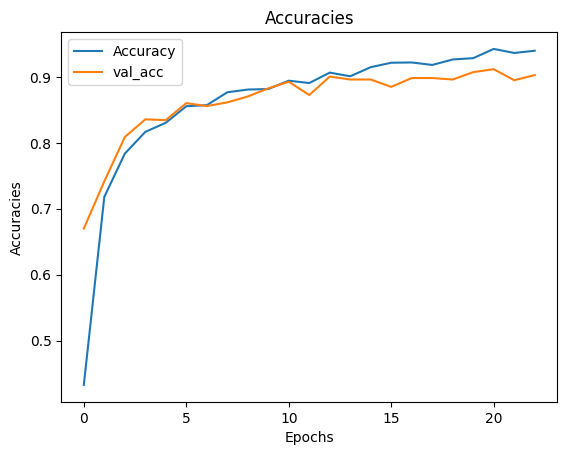

In [ ]:
#Plotting the accuracy vs the val_accuraccy
plt.plot(history.history['accuracy'])
#Extracting the model metrics stored in the history variable
plt.plot(history.history['val_accuracy'])
#Labeling the axes and the legends
plt.title("Accuracies")
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend(['Accuracy', 'val_acc'])
plt.show()

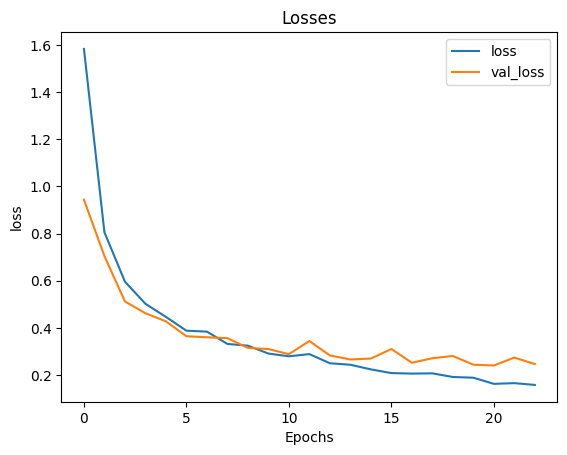

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Losses")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

## Model Evaluation

The model was trained with a high degree of accuracy, however, there is a higher difference between the loss and the validation loss. This translates to the model performing well in training but this performance is not replicated on unseen images. However, when evalauting the model on the test images, the model achieves a high accuracy of approximately 94% and low loss of 0.1612.

In [ ]:
#Evaluating the model on the test images
test_loss, test_acc = model_1.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)
print('\n Test loss:', test_loss)

30/30 - 0s - loss: 0.1612 - accuracy: 0.9436 - 389ms/epoch - 13ms/step

Test accuracy: 0.943617045879364

 Test loss: 0.16124624013900757


The model can be used to make predictions. The predications made by the model are in the form of probabilities. It calculates the probability of each image belonging to each class or label. The model was asked to predict the label of a  random image from the test set. The prediction output was a probability the image belongs to each class. The model placed the highest probability of the random image (200th image in the test set) as the 6th element at 26.8%.

In [ ]:
#Making predictions using the trained model on a random image in the test set
model_1_pred = tf.keras.Sequential([model_1,tf.keras.layers.Softmax()])
pred = model_1_pred.predict(test_images)
print(pred[200])

30/30 [==============================] - 1s 19ms/step
[0.10378569 0.10912505 0.10378461 0.10378516 0.10386617 0.10378406
 0.2680847  0.10378451]


The label belononging to the highest probabilty of the pridiction was the 6th element of the one hot encoded test labels. To see if the prediction was correct, the assigned integers to the label were printed. From that it can be seen that the number 6 belongs to the image of a motorbike.

In [ ]:
#Prinitng the label
print('label of the random prediction:',(np.argmax(pred[200])))
print('-------------------------------------------------------')

#Mapping the labels encoder to the image labels
for i, label in enumerate(train_labels_mapping):
    print(i, label)

label of the random prediction: 6
-------------------------------------------------------
0 airplane
1 car
2 cat
3 dog
4 flower
5 fruit
6 motorbike
7 person


To know if the prediction made by the model of the random image is correct, the image was plotted which showed that the model correctly identified the random image as that of a motorbike.

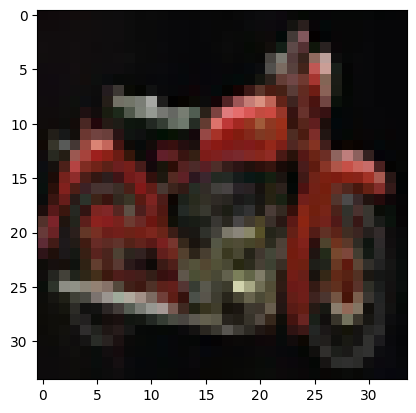

In [ ]:
plt_of_pred = test_images[200]
plt.imshow(plt_of_pred)


Plotting the confusion matrix will allow for a better understanding of predictions along with the mapped labels of the test and train labels. From the confusion matrix, the model performed very well and predicted the majority of the classes correctly from the unseen images. The largest error was in the prediction of dog images which were predicted as cats.

30/30 [==============================] - 1s 26ms/step


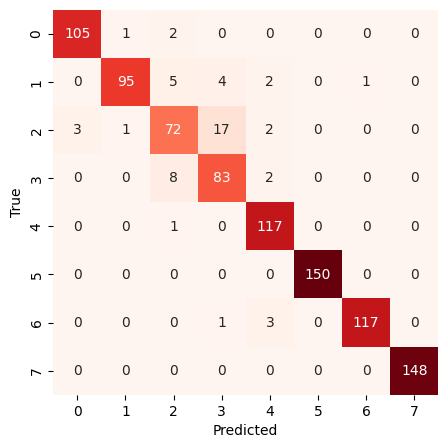

0 airplane
1 car
2 cat
3 dog
4 flower
5 fruit
6 motorbike
7 person


In [ ]:
fig = plt.figure(figsize=(5, 5))
#Getting the image predictions of the model on the test images
cm_pred = np.argmax(model_1.predict(test_images), 1)
cm_test = np.argmax(test_labels, 1)
#Calculating the confusion matrix and plotting the values
con = confusion_matrix(cm_test, cm_pred)
sns.heatmap(con.T, square=True, annot=True, cbar=False, cmap=plt.cm.Reds, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('True');
plt.show();

for i, label in enumerate(train_labels_mapping):
    print(i, label)

# Conclusion

The convolutional model designed correctly identified the majority of the test images. However, the model struggled to differentiate between the images of a cat and a dog, this might be due to the images sharing a features certain patterns that the model was unable to differentiate between. The model's prediction capabilites could be improved if the images used to train the model were larger where the convolution filter would be able identify more distinct features which was not possible due to the limited computing capabilites for this task. A larger set of images of each label could also be used to train the model so that the model learns more diverse and important features and patterns. Overall, the model performed well in identifying and distinguishing between the sets of unseen images and correctly labeling them.

In [ ]:
#HYPER-PARAMETER TUNNING TABLE.

hp={'Layers':['8', '8','8','8','9','9','9','9','9','9','9','10','9','10','10'],

'Con_act':['1-relu,2-relu', '1-relu,2-relu','1-relu,2-relu','1-relu,2-relu','1-relu,2-relu','1-relu,2-relu','1-relu,2-relu','1-tanh,2-relu','1-tanh,2-relu','1-tanh,2-relu','1-tanh,2-relu','1-relu,2-relu','1-relu,2-relu','1-relu,2-relu','1-relu,2-relu'],

'No.Fil':[('1/30','2/60'), ('1/60','2/60'),('1/60','2/60'),'(1/30,2/30)','(1/30,2/30)','(1/30,2/30)','(1/30,2/30)','(1/30,2/30)','(1/30,2/30)','(1/30,2/30','(1/30,2/30)','(1/32,2/64)','(1/30,2/30)','(1/32,2/64)','(1/32,2/64)'],

'Kernel_size':['1(3,3),2(3,3)', '1(3,3),2(3,3)','1(5,5),2(5,5)','1(3,3),2(3,3)','1(3,3),2(3,3)','1(3,3),2(3,3)','1(3,3),2(3,3)','1(3,3),2(3,3)','1(3,3),2(3,3)','1(3,3),2(3,3)','1(3,3),2(3,3)','1(3,3),2(3,3)','1(3,3),2(3,3)','1(3,3),2(3,3)','1(3,3),2(3,3)'],

'Batch':['100','100','100','100','100','150','200','200','200','200','200','200','125','100','80'],

'No. Dense_lay':['1','1','1','1','2','2','2','2','2','2','2','3','2','3','3'],

'No. Dense_neur':['1/8','1/8','1/8','1/8','1/60,2/8','1/60,2/8','1/60,2/8','1/60,2/8','1/80,2/8','1/40,2/8','1/40,2/8','1/60,2/20,3/8','1/60,2/8','1/60,2/20,3/8','1/60,2/20,3/8'],

'Dense act_func':['1-Softmax','1-Softmax','1-Softmax','1-Softmax','1-relu,2-Softmax','1-tanh,2-Softmax','1-tanh,2-Softmax','1-tanh,2-Softmax','1-tanh,2-Softmax','1-tanh,2-Softmax','1-relu,2-Softmax','1-sigmoid,2-tanh,3-Softmax','1-tanh,2-Softmax','1-Sigmoid,3-tanh,3-Softmax','1-tanh,3-tanh,3-Softmax'],

'Learn_rate':['0.001','0.001','0.001','0.001','0.001','0.001','0.001','0.0001','0.0001','0.0001','0.0001','0.001','0.001','0.001','0.001'],

'Loss':['0.1599','0.1069','0.6490','0.4914','0.2635','0.1153','0.1950','0.4992','0.4891','0.5830','0.6404','0.2082','0.1624','0.1814','0.1840'],

'Acc':['0.9463','0.9643','0.7718','0.8223','0.9001','0.9518','0.9250','0.8241','0.848','0.7962','0.7761','0.9206','0.9390','0.9364','0.9297'],

'Val_losss':['0.591',"0.6337",'0.5559','0.5213','0.5117','0.5454','0.3006','0.5333','0.5646','0.6030','0.5820','0.3189','0.3273','0.3132','0.3061'],

'Val_accuracy':['0.8826','0.8960','0.7919','0.8535','0.8490','0.8624','0.8781',' 0.8076','0.7953','0.7785','0.7964','0.926','0.8814','0.8870','0.8915']
}
